# DOODLE Customer Movement Prediction

## 1. Introduction

### 1.1 Load Packages

In [1]:
# data processing libraries
import numpy as np
import pandas as pd

In [2]:
# plotting libraries
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import datetime
from datetime import datetime as dt

In [4]:
# miscellaneous
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import normalize

## 2. Get Data

In [5]:
# read data from file
days = ['monday','tuesday','wednesday','thursday','friday']
df = {}
for day in days:
    file_path = '../data/'+day+'.csv'
    df[day] = pd.read_csv(file_path,sep=';')

### 2.1 Quick Exploration

#### check data head

In [6]:
for day in days:
    print(f'\n{day}:\n {df[day].head()}')


monday:
              timestamp  customer_no location
0  2019-09-02 07:03:00            1    dairy
1  2019-09-02 07:03:00            2    dairy
2  2019-09-02 07:04:00            3    dairy
3  2019-09-02 07:04:00            4    dairy
4  2019-09-02 07:04:00            5   spices

tuesday:
              timestamp  customer_no location
0  2019-09-03 07:02:00            1    fruit
1  2019-09-03 07:02:00            2   drinks
2  2019-09-03 07:03:00            3    dairy
3  2019-09-03 07:05:00            1   drinks
4  2019-09-03 07:06:00            4    dairy

wednesday:
              timestamp  customer_no location
0  2019-09-04 07:00:00            1    fruit
1  2019-09-04 07:00:00            2    dairy
2  2019-09-04 07:00:00            3    fruit
3  2019-09-04 07:00:00            4    fruit
4  2019-09-04 07:00:00            5    dairy

thursday:
              timestamp  customer_no  location
0  2019-09-05 07:00:00            1    drinks
1  2019-09-05 07:01:00            2     fruit
2  201

*Observation 1: There is repetation of customer number from day to day*
<br>
*Observation 2: Earliest checkin time 07:00*

#### check data tail

In [7]:
for day in days:
    print(f'\n{day}:\n {df[day].tail()}')


monday:
                 timestamp  customer_no  location
4879  2019-09-02 21:49:00         1442  checkout
4880  2019-09-02 21:49:00         1444  checkout
4881  2019-09-02 21:49:00         1445     dairy
4882  2019-09-02 21:50:00         1446     dairy
4883  2019-09-02 21:50:00         1447     fruit

tuesday:
                 timestamp  customer_no  location
4709  2019-09-03 21:47:00         1421    drinks
4710  2019-09-03 21:47:00         1422     dairy
4711  2019-09-03 21:48:00         1421  checkout
4712  2019-09-03 21:49:00         1412  checkout
4713  2019-09-03 21:50:00         1411     dairy

wednesday:
                 timestamp  customer_no  location
5045  2019-09-04 21:48:00         1528    spices
5046  2019-09-04 21:49:00         1520     dairy
5047  2019-09-04 21:49:00         1529     dairy
5048  2019-09-04 21:49:00         1530     fruit
5049  2019-09-04 21:49:00         1531  checkout

thursday:
                 timestamp  customer_no  location
5099  2019-09-05 21:48:

*Observation: Last checkout time is 21:50*

#### check missing values

In [8]:
for day in days:
    print(f'\n{day}:')
    print(f'{df[day].isna().sum()}')


monday:
timestamp      0
customer_no    0
location       0
dtype: int64

tuesday:
timestamp      0
customer_no    0
location       0
dtype: int64

wednesday:
timestamp      0
customer_no    0
location       0
dtype: int64

thursday:
timestamp      0
customer_no    0
location       0
dtype: int64

friday:
timestamp      0
customer_no    0
location       0
dtype: int64


*Observation: There are no missing values*

#### check customer info

In [9]:
for day in days:
    print(f'\n{day} customer\n')
    tracked = df[day]['customer_no'].count()
    unique = df[day]['customer_no'].nunique()
    min_no = df[day]['customer_no'].min()
    max_no = df[day]['customer_no'].max()
    print(f'   tracked: {tracked}, unique: {unique}, min_no: {min_no}, max_no: {max_no}')


monday customer

   tracked: 4884, unique: 1447, min_no: 1, max_no: 1447

tuesday customer

   tracked: 4714, unique: 1422, min_no: 1, max_no: 1422

wednesday customer

   tracked: 5050, unique: 1531, min_no: 1, max_no: 1531

thursday customer

   tracked: 5104, unique: 1535, min_no: 1, max_no: 1535

friday customer

   tracked: 5125, unique: 1510, min_no: 1, max_no: 1510


*Observation:Customers are tracked at multiple locations. Number of unique customers in a day < 2000.*

#### check data info

In [10]:
for day in days:
    print(f'\n{day}:\n')
    print(df[day].info())


monday:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4884 entries, 0 to 4883
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   timestamp    4884 non-null   object
 1   customer_no  4884 non-null   int64 
 2   location     4884 non-null   object
dtypes: int64(1), object(2)
memory usage: 114.6+ KB
None

tuesday:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4714 entries, 0 to 4713
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   timestamp    4714 non-null   object
 1   customer_no  4714 non-null   int64 
 2   location     4714 non-null   object
dtypes: int64(1), object(2)
memory usage: 110.6+ KB
None

wednesday:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   timestamp    5050 non-null   object
 

*Comment:timestamp needs to be converted to datetime object*

### 2.2 Data Pre-Processing:

#### Pre-process daily data

In [11]:
for i in range(len(days)):
    # make unique customer number throughout the week (jump 2000 each day)
    df[days[i]]['customer_no'] = df[days[i]]['customer_no'] + 2000*i
    # create time column
    df[days[i]]['time'] = df[days[i]]['timestamp'].apply(lambda x: dt.strptime(x,'%Y-%m-%d %H:%M:%S').time())
    # drop timestamp column
    df[days[i]].drop('timestamp',axis=1,inplace=True)

#### Merge dataframes

In [12]:
# concatenate the dataframes
df_all = pd.concat(list(df.values()))
df_all.head()

,customer_no,location,time
0,1,dairy,07:03:00
1,2,dairy,07:03:00
2,3,dairy,07:04:00
3,4,dairy,07:04:00
4,5,spices,07:04:00


In [13]:
df_all.shape

(24877, 3)

## 3. Data Exploration

#### Total number of customers in each section

In [14]:
sectionwise = df_all.groupby('location')[['customer_no']].nunique().reset_index()
sectionwise = sectionwise[sectionwise['location']!='checkout']
sectionwise

,location,customer_no
1,dairy,3818
2,drinks,3214
3,fruit,4284
4,spices,2938


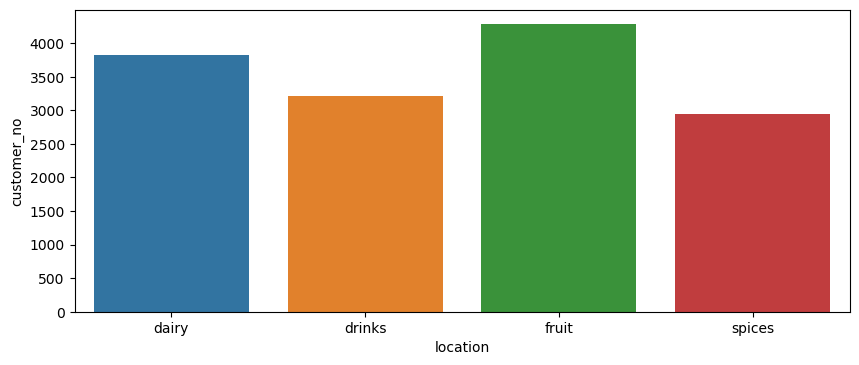

In [15]:
plt.figure(figsize=(10,4),dpi=100)
sns.barplot(x='location',y='customer_no',data=sectionwise)
None

#### Claim: Some customers' checkout is missing! This is seen below

In [16]:
# set of all customers
customers = set(df_all['customer_no'])

# set of customers that checked out
checkout = set(df_all[df_all['location']=='checkout']['customer_no'])

# set of customers with missing checkout
no_checkout = customers - checkout

print(f'customers without checkout info: {len(no_checkout)}')

customers without checkout info: 28


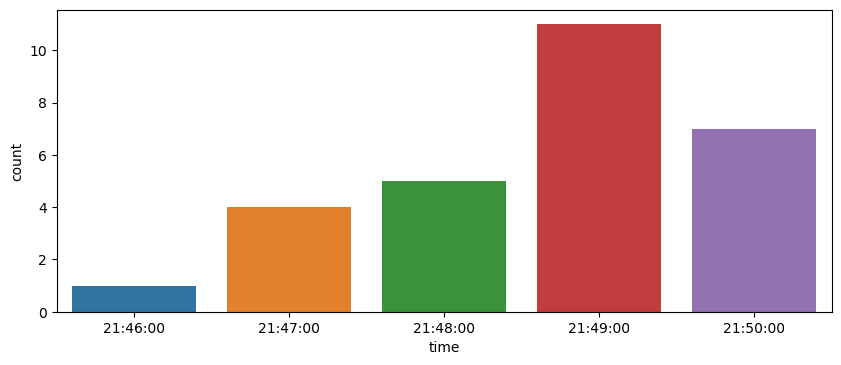

In [17]:
# dataframe slice for customers without checkout info
df_no_checkout = df_all[df_all['customer_no'].isin(no_checkout)]

# dataframe for last location of customer
df_no_checkout = df_no_checkout.groupby('customer_no')[['time']].max().reset_index()

# count plot of anomalous last location at last tracking time
plt.figure(figsize=(10,4),dpi=100)
sns.countplot(df_no_checkout.sort_values(by='time')['time'])
None

*Observation: Last tracking time of customers without checkout info is close to final checkout time*

#### Append dataframe for customers with missing checkout info

In [18]:
# appending dataframe with forced checkout info

# forced checkout time 21:50:01 chosen for convenience
last_checkout = dt.strptime('21:50:01','%H:%M:%S').time()

# dictionary
dict_append = {'customer_no': sorted(list(no_checkout)),
               'location': ['checkout']*len(no_checkout),
               'time': [last_checkout]*len(no_checkout)
              }

# dataframe
df_append = pd.DataFrame(data = dict_append)

# concatenation
df_all = pd.concat([df_all,df_append])

#### Total number of customers in each section over time

In [19]:
# add the monday date to time for convenience
date = datetime.date(2019,9,2)

df_all['hour'] = df_all['time'].apply(lambda x: dt.combine(date,x).hour)
location_hourly = df_all.groupby(['location','hour'])[['customer_no']].nunique().reset_index()

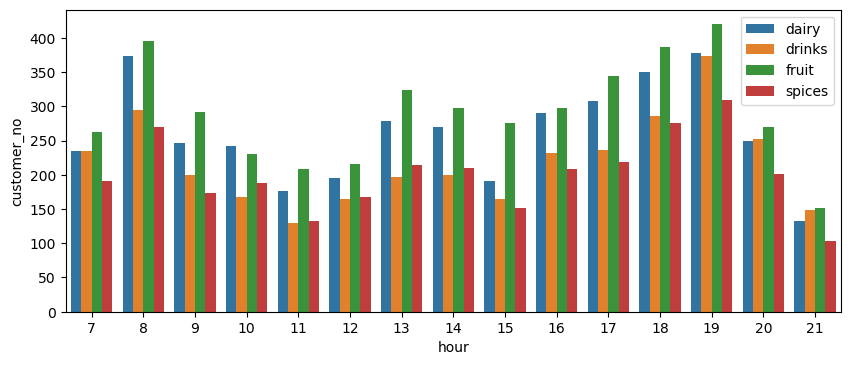

In [20]:
section_hourly = location_hourly[location_hourly['location']!='checkout']

plt.figure(figsize=(10,4),dpi=100)
sns.barplot(x='hour',y='customer_no',hue='location',data=section_hourly)
plt.legend(loc=1)
None

#### Plot number of customers at checkout over time

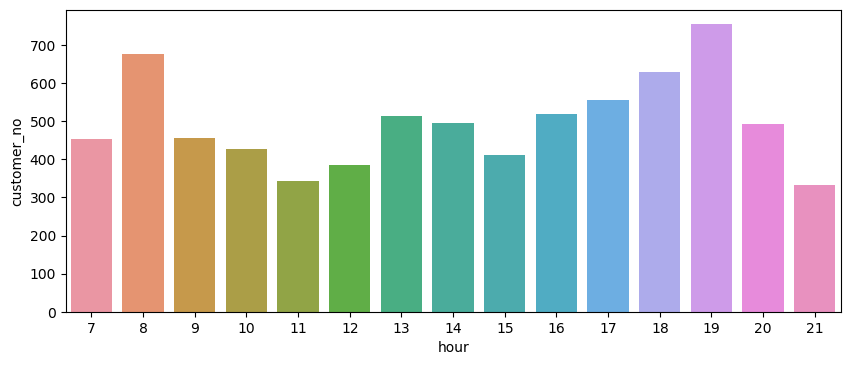

In [21]:
checkout_hourly = location_hourly[location_hourly['location']=='checkout']

plt.figure(figsize=(10,4),dpi=100)
sns.barplot(x='hour',y='customer_no',data=checkout_hourly)
None

#### Total number of customers over time

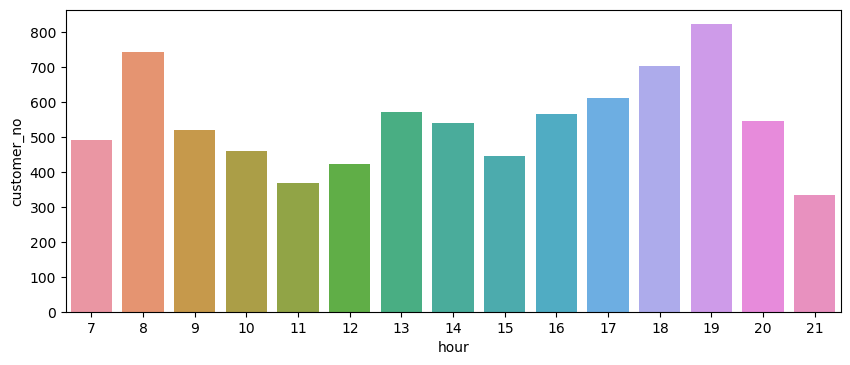

In [22]:
total_hourly = df_all.groupby('hour')[['customer_no']].nunique().reset_index()

plt.figure(figsize=(10,4),dpi=100)
sns.barplot(x='hour',y='customer_no',data=total_hourly)
None

#### Customers every minute 

In [23]:
# list of possible entry munbers in a minute 
no_of_entry = [i for i in range(12)]

# find entry time of customer
df_entry = df_all.groupby('customer_no')[['time']].min().reset_index()

# opening: 7:00, closing: 21:50
minutes_in_day = (21-7)*60 + 50

# count customer entering in given minute everyday
frequency = np.zeros(12)
for i in range(len(days)):
    # slice out out the dataframe
    df_x = df_entry[(df_entry['customer_no']>2000*i)&(df_entry['customer_no']<2000*(i+1))]
    
    # number of missing minutes
    missing_minutes = minutes_in_day - df_x['time'].nunique()
    
    # count customers coming in in a minute
    df_x = df_x.groupby('time')['customer_no'].count().reset_index()
    
    # value count
    df_freq = pd.DataFrame(df_x['customer_no'].value_counts())
    a,freq = list(df_freq.index), list(df_freq['customer_no'])

    # add zero customer
    a.append(0)
    freq.append(missing_minutes)
    
    # add other possible missing values
    missing = list(set(no_of_entry) - set(a))
    a.extend(missing)
    freq.extend([0]*len(missing))
    
    # sort values
    zipped = sorted(list(zip(a,freq)),key=lambda x: x[0])
    freq_ordered = np.array([zipped[i][1] for i in range(len(zipped))])
    
    # add daily values
    frequency += freq_ordered

# calculate probability
prob = [i/sum(frequency) for i in frequency]

In [24]:
# save as json
import json
with open('../data/customer_number_prob.json', 'w') as fp:
    json.dump(prob, fp)

### 3.1 Customer Movement Dataset

In [25]:
# assign a letter for each section
letter = {'fruit':'f','spices':'s','dairy':'d','drinks':'k'}

# sort data by customer_no and then by time
df_path = df_all.sort_values(by =['customer_no','time'])

# find minutes spent in a location
df_path['spent_min'] = df_path['time'].apply(lambda x: dt.combine(date,x)).diff(periods=1).shift(-1)
df_path = df_path[df_path['location']!='checkout']
df_path['spent_min'] = df_path['spent_min'].apply(lambda x: int(x.seconds/60))
    
# find path string for the customer
df_path['path'] = df_path.apply(lambda x: letter[x['location']]*x['spent_min'],axis=1)

# make dataframe for customer path
df_path = df_path.groupby('customer_no')['path'].sum().reset_index()
df_path.head()

,customer_no,path
0,1,dd
1,2,ddd
2,3,dd
3,4,dddd
4,5,s


#### Save file

In [26]:
# save the path dataframe as csv file
df_path.to_csv('path_data.csv')

#### Customer time spent in the market

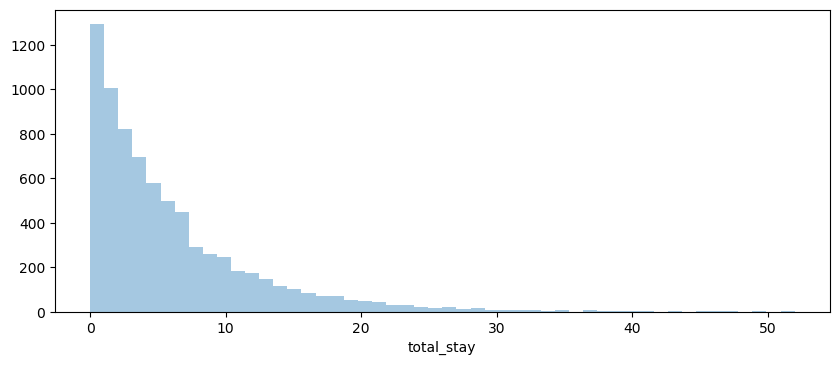

In [27]:
# compute spent time
df_path['total_stay'] = df_path['path'].apply(lambda x: len(x))

plt.figure(figsize=(10,4),dpi=100)
sns.distplot(df_path['total_stay'],kde=False)
None

In [28]:
mean_stay = round(df_path['total_stay'].mean(),2)
median_stay = round(df_path['total_stay'].median(),2)
print(f'average_stay: {mean_stay } min') 
print(f'median_stay : {median_stay} min')

average_stay: 6.25 min
median_stay : 4.0 min


#### Distribution of customers of first visited section vs following sections

In [29]:
df_path['first_section'] = df_path['path'].apply(lambda x: 0 if x=='' else x.count(x[0]))
df_path['following_sections'] = df_path['total_stay']-df_path['first_section']
df_path.head()

,customer_no,path,total_stay,first_section,following_sections
0,1,dd,2,2,0
1,2,ddd,3,3,0
2,3,dd,2,2,0
3,4,dddd,4,4,0
4,5,s,1,1,0


In [30]:
df_stay = pd.DataFrame(data=df_path[['first_section','following_sections']].stack(),columns=['min_spent'])
df_stay.reset_index(inplace=True)
df_stay.head()

,level_0,level_1,min_spent
0,0,first_section,2
1,0,following_sections,0
2,1,first_section,3
3,1,following_sections,0
4,2,first_section,2


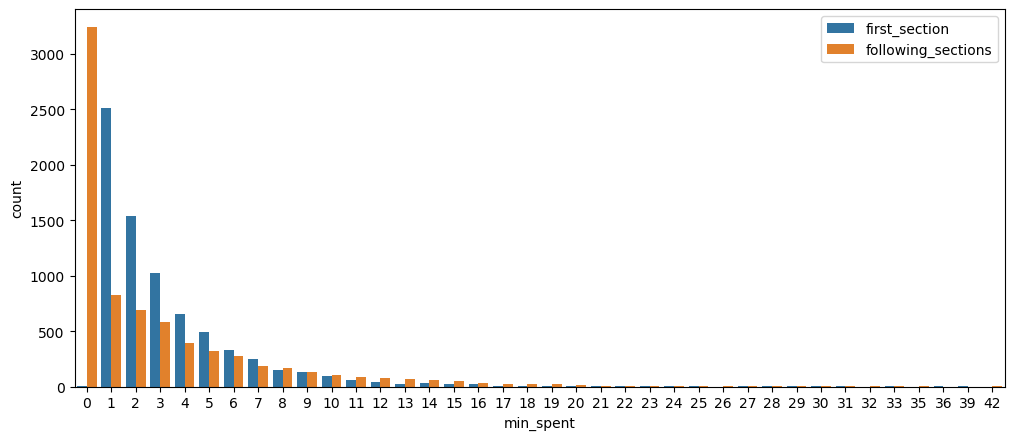

In [31]:
plt.figure(figsize=(12,5),dpi=100)
sns.countplot(data=df_stay,x='min_spent', hue='level_1')
plt.legend(loc=1)
None

#### Revenue Estimate

In [32]:
def revenue(customer_no):
    df = df_path.set_index('customer_no')
    rev_map = {'f':4,'s':3,'d':5,'k':6}
    path = df.loc[customer_no]['path']
    revenue = sum([rev_map[letter] for letter in path])
    print(f'revenue for customer {customer_no}: {revenue} Euros')

In [33]:
revenue(customer_no=1231)

revenue for customer 1231: 54 Euros
